## Duplicate image detection

https://www.kaggle.com/iezepov/get-hash-from-images-slightly-daster

https://blog.iconfinder.com/detecting-duplicate-images-using-python-cb240b05a3b6

https://www.pyimagesearch.com/2017/11/27/image-hashing-opencv-python/

In [1]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd
import os
import csv
from resources.conv_learner import *


# required to get individual channels out of image object
from PIL import Image, ImageSequence

### (1) OPTIONAL: Generate csv from image folder:

In [ ]:
def HPAv18_csv_from_dir(path, folder, outfile):
    
    ### makes csv from images in folder ###

    _fnames = read_dir(path, folder)
    
    # note use of rsplit (!)
    df_fnames = pd.DataFrame([os.path.basename(_fnames[i]).split('.')[0].rsplit('_',1)[0] for i, _ in enumerate(_fnames)])
    uni_fnames = df_fnames[0].drop_duplicates(); # only unique fnames
   
    
    return uni_fnames

In [ ]:
path = 'datasets/HPA_challenge_2018/'
folder = 'HPA_multiproc_test'
outfile = 'HPAv18_labels_test.csv'

HPAv18_df = HPAv18_csv_from_dir(path, folder, outfile)

In [ ]:
HPAv18_df.to_csv(path + outfile, index=False, header=False)

### (2) Remove non-60x images identified by 'si' substring:

In [45]:
def purge_by_ID_substring(csv_file, substring):
    
    ### open original HPAv18RBGY_wodpl.csv 
    HPAv18_df = pd.read_csv(csv_file)

    ### select Id's containing 'si' and drop them from df
    containing_rows = HPAv18_df.Id.str.contains(substring)
    res_df = HPAv18_df.drop(HPAv18_df[containing_rows].index)
    
    print(f"Removed {len(HPAv18_df) - len(res_df)} files based on substring: {substring}")
    
    return res_df

In [46]:
path = 'datasets/HPA_challenge_2018/'
csv_file = path + 'HPAv18RBGY_wodpl.csv'

HPAv18_60x = purge_by_ID_substring(csv_file, substring = 'si')
HPAv18_60x.to_csv(path + 'HPAv18_wodpl_60x.csv', index=False)

Removed 1574 files based on substring: si


In [44]:
# !rm datasets/HPA_challenge_2018/HPAv18_wodpl_60x.csv

In [ ]:
# remove *si* containing images from csv and source folder; they are not 60x!

print(len(os.listdir('datasets/HPA_challenge_2018/HPAv18_BGR_all')))
# !rm datasets/HPA_challenge_2018/HPAv18_BGR_all/*si* 
print(len(os.listdir('datasets/HPA_challenge_2018/HPAv18_BGR_all')))

### (3) Generate dhashes of images for 'needles' and 'haystack'

In [5]:
from tqdm import tqdm_notebook as tqdm
from HPAv18_ImCompare import *

def get_im_paths(path, folders):
    
    fnames = []
    
    for f in folders:
        _fnames = read_dir(path, f)
        _fnames = [[f, _fnames[i]] for i, _ in enumerate(_fnames)] # remove idx to get all !!!
        fnames = fnames + _fnames
    
    res = np.vstack(fnames)
    print(f"Total images: {len(res)}")
    return res


def get_im_hash_per_channel(im_paths, hash_func, **kwargs):
    """
    Available hash_functions implemented in HPAv18_ImCompare.py:
    1) Difference hash v1: dhash_v1
    2) Difference hash v2: dhash_v2
    3) Average hash: average_hash
    4) Perception hash: phash
    """
    hs = []
    print(f"dhashing images...")

    for im_name in tqdm(im_paths, total = len(im_paths), unit="files"):
        im = Image.open(path + im_name)

        # might want to add options for different channels here
        h = [hash_func(ch, **kwargs) for ch in ImageSequence.Iterator(im)]
        hs.append(h)
    
    res = np.concatenate([im_paths[:,None], np.vstack(hs)], axis=1)
    return res

In [4]:
path = 'datasets/HPA_challenge_2018/'

In [ ]:
# define sources
needles_folders = ['train_BGR_all','test_BGR_all']
haystack_folders = ['HPAv18_BGR_all']

# # get image paths:
needles_path = get_im_paths(path, needles_folders)
haystack_path = get_im_paths(path, haystack_folders)

# get image hashesh for each channel:

needles = get_im_hash_per_channel(needles_path[:,1], phash, hash_size=8) #default = phash
haystack = get_im_hash_per_channel(haystack_path[:,1], phash, hash_size=8) #default = phash

"""
Save to csv:
"""
# pd.DataFrame(needles).to_csv(path + 'needles.csv')
# pd.DataFrame(haystack).to_csv(path + 'haystack_no_si.csv')

In [34]:
"""
Load from saved csv:
"""
needles = pd.read_csv(path + 'needles.csv').values[1:,1:]
haystack = pd.read_csv(path + 'haystack_no_si.csv').values[1:,1:]

In [41]:
len(needles)

42773

### (4) Detect duplicates based on hamming_distance between dhashes

In [37]:
def hamming_distance(s1, s2):
    """Return the Hamming distance between equal-length sequences"""
    if len(s1) != len(s2):
        raise ValueError("Undefined for sequences of unequal length")
    return sum(el1 != el2 for el1, el2 in zip(s1, s2))

def find_dupes(needles, haystack, th = 10):
    """
    Finds duplicate images based on hamming_distance between image hashes.
    Default threshold for dupe-detection = 10 per channel.
    
    Input: lists of format ['im_needle', [ch1_hash, ch2_hash, ...]]
    Output: Pandas Dataframe
    """
    dupes = []
    n_chans = len(needles[0][1])
    
    for n_im, n_hashes in tqdm(needles, total=len(needles), unit='files'):
        for h_im, h_hashes in haystack:
            _dist = np.array(list(map(lambda x,y: hamming_distance(x,y), n_hashes, h_hashes)))
            if _dist.sum() < th * n_chans: 
                dupes.append([n_im, h_im, *_dist])

    print(f'Duplicates found: {len(dupes)}')
    cols = ['Id', 'dupe'] + [f"Hdist_{c}" for c in range(n_chans)]

    return pd.DataFrame(dupes, columns= cols)


def find_dupes_v2(needles, haystack, th=10):
    dupes = []
    n_chans = len(needles[0,1:])

    for n_im, *n_hashes in tqdm(needles, total=len(needles), unit='files'):
        _dist = np.array([list(map(lambda x,y: hamming_distance(x,y), n_hashes, h_hashes)) for h_im, *h_hashes in haystack])
        _idx = np.flatnonzero(_dist.sum(axis=1) < th * n_chans)
        _dupes = haystack[:,0][_idx]
        
        if len(_dupes) > 0: # duplicate found!
            dupes.extend([[n_im, j, *_dist[_idx][i]] for i, j in enumerate(_dupes)])

    print(f'Duplicates found: {len(dupes)}')
    cols = ['Id', 'dupe'] + [f"Hdist_{c}" for c in range(n_chans)]

    return pd.DataFrame(dupes, columns= cols)

In [97]:
### testing with confirmed duplicate images from Tomomimoriayama_test_matches.csv

test_needles = np.array(['test_BGR_all/' + '7729b27c-bacc-11e8-b2b8-ac1f6b6435d0' + '.tiff',
               'test_BGR_all/' + '5661665e-bacf-11e8-b2b8-ac1f6b6435d0' + '.tiff',
               'test_BGR_all/' + 'b029f372-bad9-11e8-b2b9-ac1f6b6435d0' + '.tiff',
               'test_BGR_all/' + 'adc182fa-bad2-11e8-b2b8-ac1f6b6435d0' + '.tiff',])

test_haystack = np.array(['HPAv18_BGR_all/' + '44431_556_B9_1' + '.tiff',
                'HPAv18_BGR_all/' + '44431_556_B9_1' + '.tiff',
                'HPAv18_BGR_all/' + '44431_556_B9_1' + '.tiff',
                'HPAv18_BGR_all/' + '35086_383_E8_7' + '.tiff',
                'HPAv18_BGR_all/' + '47377_688_E7_10' + '.tiff',
                'HPAv18_BGR_all/' + '63771_1414_D12_2' + '.tiff',])



needle_h = get_im_hash_per_channel(test_needles, phash, hash_size=8)
hay_h = get_im_hash_per_channel(test_haystack, phash, hash_size=8)

check = find_dupes_v2(needle_h, hay_h)
check

In [52]:
dupe_df = find_dupes_v2(needles, haystack)
# dupe_df.head(10)
dupe_df.to_pickle(path + 'HPAv18_dupes_no_si_phash_10_BGR.pkl')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Duplicates found: 6945


In [ ]:
dupe_df.to_csv(path + 'HPAv18_dupes_no_si_phash_10_BGR.csv')
dupe_df.to_pickle(path + 'HPAv18_dupes_no_si_phash_10_BGR.pkl')

In [5]:
dupe_df = pd.read_pickle(path + 'HPAv18_dupes_no_si_phash_10_BGR.pkl')

In [6]:
### On the assumption that there are NO duplicates among train & test (needles) folders, 
### there should be NO duplicates in dupe_df.dupes - others must be false positives...
### -> any duplicates found in dupe_df.dupe can be discarded.

print(f'Total images in dupes: {len(dupe_df.dupe)}')
print(f'Unique images in dupes: {len(dupe_df.dupe.drop_duplicates())}')
print(f"Unique test-dupes: {len(dupe_df.dupe[dupe_df.Id.str.contains('test')].drop_duplicates())}")

Total images in dupes: 6945
Unique images in dupes: 6704
Unique test-dupes: 409


### Explore other hash-functions for dupe-detection:

Perception-hashing with threshold=10 may be too liberal: after manual check, there ARE false positives in dupes_df.
An idea may be running a different type of hashing on the dupes detected with phash...

#### Average_hashing with average_hash

In [96]:
needles_paths_post_phash = np.array(dupe_df.Id.drop_duplicates())
haystack_paths_post_phash = np.array(dupe_df.dupe.drop_duplicates())

needles_post_phash = get_im_hash_per_channel(needles_paths_post_phash, average_hash, hash_size=8) #default = phash
haystack_post_phash = get_im_hash_per_channel(haystack_paths_post_phash, average_hash, hash_size=8) #default = phash

dupe_df_average_hash = find_dupes_v2(needles_post_phash, haystack_post_phash)
### result seems very liberal...

dhashing images...


dhashing images...


In [127]:
print(len(dupe_df_average_hash.Id))
print(len(dupe_df_average_hash.Id.drop_duplicates()))
print(len(dupe_df_average_hash.dupe.drop_duplicates()))
print(f"Unique test-dupes: {len(dupe_df_average_hash.dupe[dupe_df_average_hash.Id.str.contains('test')].drop_duplicates())}")

17691
6638
6536
Unique test-dupes: 732


#### Difference_hashing with dhash_v2

In [99]:
needles_post_phash_dhashv2 = get_im_hash_per_channel(needles_paths_post_phash, dhash_v2, hash_size=8) #default = phash
haystack_post_phash_dhashv2 = get_im_hash_per_channel(haystack_paths_post_phash, dhash_v2, hash_size=8) #default = phash

dupe_df_dhashv2 = find_dupes_v2(needles_post_phash_dhashv2, haystack_post_phash_dhashv2)

dhashing images...


dhashing images...


In [129]:
print(len(dupe_df_dhashv2.Id))
print(len(dupe_df_dhashv2.Id.drop_duplicates()))
print(len(dupe_df_dhashv2.dupe.drop_duplicates()))
print(f"Unique test-dupes: {len(dupe_df_dhashv2.dupe[dupe_df_dhashv2.Id.str.contains('test')].drop_duplicates())}")

7473
6474
6374
Unique test-dupes: 387


### (5) Evaluate detected dupes:

Images split into definite and possible dupes, based on sum of hamming_distances for 3-channels, in interval of [0:10], [11:max] ...

In [3]:
import skimage.external.tifffile as tiff

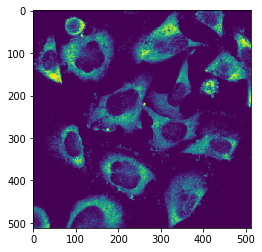

In [8]:
# im = plt.imread('datasets/HPA_challenge_2018/HPAv18_BGRY_source/11311_88_G2_1-green.png')
# plt.imshow(im)

In [7]:
dupe_phash_work = dupe_df.copy()

In [8]:
dupe_phash_work['dist_sum'] = dupe_phash_work.Hdist_0 + dupe_phash_work.Hdist_1 + dupe_phash_work.Hdist_2

In [9]:
definite_dupes = dupe_phash_work[dupe_phash_work.dist_sum.between(0,10,inclusive=True)]
possible_dupes = dupe_phash_work[dupe_phash_work.dist_sum.between(11,50,inclusive=True)]

print(len(definite_dupes), len(possible_dupes))
print(f"Unique definite train-dupes: {len(definite_dupes.dupe[definite_dupes.Id.str.contains('train')].drop_duplicates())}")
print(f"Unique possible train-dupes: {len(possible_dupes.dupe[possible_dupes.Id.str.contains('train')].drop_duplicates())}")

print(f"Unique definite test-dupes: {len(definite_dupes.dupe[definite_dupes.Id.str.contains('test')].drop_duplicates())}")
print(f"Unique possible test-dupes: {len(possible_dupes.dupe[possible_dupes.Id.str.contains('test')].drop_duplicates())}")
         
definite_test_dupes = definite_dupes[definite_dupes.Id.str.contains('test')]
definite_train_dupes = definite_dupes[definite_dupes.Id.str.contains('train')]

# definite_train_dupes[definite_train_dupes.duplicated('dupe', keep=False)]
# definite_dupes.sort_values(by=['dist_sum'], ascending=False)[:20]

6193 752
Unique definite train-dupes: 5886
Unique possible train-dupes: 527
Unique definite test-dupes: 225
Unique possible test-dupes: 185


In [10]:
definite_test_dupes.sort_values(by=['dist_sum'], ascending=False)[:20]

,Id,dupe,Hdist_0,Hdist_1,Hdist_2,dist_sum
6819,test_BGR_all/9e6fe8be-bad2-11e8-b2b8-ac1f6b643...,HPAv18_BGR_all/47106_807_C2_3.tiff,4,3,3,10
6581,test_BGR_all/a56d3f98-bacf-11e8-b2b8-ac1f6b643...,HPAv18_BGR_all/47373_820_G4_3.tiff,2,6,2,10
6671,test_BGR_all/29414644-bad4-11e8-b2b8-ac1f6b643...,HPAv18_BGR_all/28710_1711_B12_3.tiff,2,2,6,10
6533,test_BGR_all/ceefdbbc-bacc-11e8-b2b8-ac1f6b643...,HPAv18_BGR_all/31770_690_C10_2.tiff,4,4,2,10
6782,test_BGR_all/17d8a71c-bacf-11e8-b2b8-ac1f6b643...,HPAv18_BGR_all/60088_1308_A5_4.tiff,4,2,3,9
6706,test_BGR_all/c1dc11c4-bacd-11e8-b2b8-ac1f6b643...,HPAv18_BGR_all/25458_665_F8_4.tiff,4,3,2,9
6532,test_BGR_all/adc182fa-bad2-11e8-b2b8-ac1f6b643...,HPAv18_BGR_all/63771_1414_D12_2.tiff,0,2,6,8
6906,test_BGR_all/adfa9e8e-bac6-11e8-b2b7-ac1f6b643...,HPAv18_BGR_all/67443_1754_G2_34.tiff,0,2,6,8
6731,test_BGR_all/70f3e586-bacb-11e8-b2b8-ac1f6b643...,HPAv18_BGR_all/50808_850_C1_9.tiff,2,2,4,8
6669,test_BGR_all/429edd76-bada-11e8-b2b9-ac1f6b643...,HPAv18_BGR_all/64316_1213_C4_3.tiff,0,4,4,8


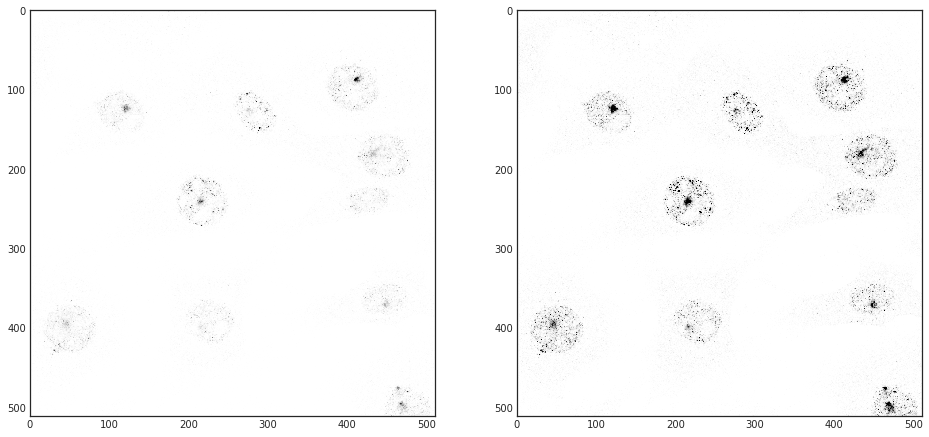

In [213]:
# test_BGR_all/2e2f56fa-bacf-11e8-b2b8-ac1f6b643...	HPAv18_BGR_all/49352_927_F12_11.tiff	
plt.style.use('seaborn-white')
ch = 1

test_im = tiff.imread(path + 'test_BGR_all/' + '2e2f56fa-bacf-11e8-b2b8-ac1f6b6435d0' + '.tiff')
# HPAv18_im = tiff.imread(path + 'HPAv18_BGR_all/' + '49352_927_F12_11' + '.tiff')
HPAv18_im = tiff.imread(path + 'test_BGR_all/' + '3323fc06-bad4-11e8-b2b8-ac1f6b6435d0' + '.tiff')

fig, ax = plt.subplots(1,2, figsize=(16,10))
ax[0].imshow(test_im[ch])
ax[1].imshow(HPAv18_im[ch])


In [ ]:
idx = 63
ch_num = 3

Bait_im = dupe_df.Id[idx]
Prey_ims = dupe_df.duplicates[idx]
targets = [Bait_im, *Prey_ims]

x = len(targets)

sz = 4 * x # dynamic scaling of figuresize

# plotting:
plt.figure(figsize=(12,sz))
gs1 = plt.GridSpec(x,3)
gs1.update(wspace = 0.4)


row = 0
print(f"Bait: {idx}/{len(dupe_df)}: {Bait_im}")
print(f"Prey: {targets[1:]}")

for i, targ in enumerate(targets):
    for ch in range(ch_num):
        ax1 = plt.subplot(gs1[i + ch + row])
        ax1.imshow(tiff.imread(path + targ)[ch])
        if i == 0: ax1.set_title(f"Bait_image : {ch}")
        else: ax1.set_title(f"Hamming_dist: {dupe_df.hamming_dist[idx][i - 1]}")
    row += 2
    #     ax1.set_xlim(0,1)

plt.show()

In [ ]:
# confirmed_dupes = []
# confirmed_dupes.append('HPAv18_BGR_all/42907_1134_E12_2.tiff')
# confirmed_dupes

In [ ]:
# append purged_df to HPA_labels.csv and save as HPA_extended_data.csv
# Option 1: delete duplicate images in HPAv18 folder; then proceed...
# Option 2: bash copy all original data into HPAv18 (faster than other way around)
# Option 3: leave files in respective folders; modify csv's to include partial path...

In [48]:
def remove_dupes(target_csv, dupes_df):
    
    orig_df = pd.read_csv(path + target_csv)
    purged_df = orig_df.copy()
    
    for im in tqdm(dupes_df.dupe, total=len(dupes_df), unit='items'):
        dupe = os.path.basename(im).split('.')[0]
        dupe_idx = orig_df[(orig_df.Id == dupe)].index
        purged_df = purged_df.drop(dupe_idx)
            
    print(f'Total images removed: {len(orig_df) - len(purged_df)}')

    return purged_df, orig_df

In [49]:
### Remove "duplicate" dupes from input...

definite_dupes_unique = definite_dupes.drop_duplicates('dupe')
print(len(definite_dupes))
print(len(definite_dupes_unique))

6193
6111


In [50]:
csv_file = 'HPAv18_wodpl_60x.csv' ### NO non-60x images...

HPAv18_def_dupes_removed, HPAv18_orig = remove_dupes(csv_file, definite_dupes_unique)

print(f"Remaining images in purged csv: {len(HPAv18_def_dupes_removed)}")
HPAv18_def_dupes_removed.head(10)

100%|██████████| 6111/6111 [01:12<00:00, 84.12items/s]
Total images removed: 6111
Remaining images in purged csv: 66921


,Id,Target
0,10580_1610_C1_1,13 25 0 2 21
1,10580_1610_C1_2,13 25 0 2 21
2,10580_1756_B1_1,13 25 0 2 21
3,10580_1756_B1_2,13 25 0 2 21
6,10814_50_A1_1,6
7,10814_50_A1_2,6
8,10814_51_A1_1,6
9,10814_51_A1_2,6
10,10814_856_E12_1,6
12,11311_88_G2_1,25 6


In [54]:
# !rm datasets/HPA_challenge_2018/HPAv18_60x_def_dupes_removed.csv

In [55]:
# save purged csv:
HPAv18_def_dupes_removed.to_csv(path + 'HPAv18_60x_def_dupes_removed.csv', index=False)

In [57]:
HPAv18_60x_def_dupes_removed = pd.read_csv(path + 'HPAv18_60x_def_dupes_removed.csv')
len(HPAv18_60x_def_dupes_removed)

66921

In [ ]:
# Options 3: modifying csv's to include partial path to folders - this way, merging folders can be avoided.

In [ ]:
# add partial path to Id's in csv's

def add_partial_path(df, partial_path):
    for n in tqdm(df.Id, total = len(df.Id), unit="files"):
        df.Id.replace(n, 'test/' + n, inplace=True) 
    return df

In [3]:
!ls 

FIJI_scripts
HPAv18_ImCompare.py
HPAv18_duplicate_image_detection.ipynb
HPAv18_external_data_download.ipynb
HPAv18_find_dupes_multiproc.py
HPAv18_multiproc_download_AWS.py
Hirano3D_data_handling_v1.ipynb
Hirano3D_v1_Res18_local_v1.ipynb
Kaggle_Data_handling.ipynb
Kaggle_Data_handling_save.ipynb
Kaggle_HPA_First_model_AWS_v1.1.ipynb
Kaggle_HPA_First_model_WP.ipynb
Kaggle_HPA_First_model_WP_v1.0.ipynb
Kaggle_HPA_First_model_WP_v1.1.ipynb
Kaggle_HPA_First_model_WP_v2_BGR.ipynb
Kaggle_HPA_First_model_WP_v3_BGR_AWS.ipynb
Kaggle_HPA_First_model_WP_v3_BGR_local.ipynb
Local
MNIST_to_jpg.ipynb
MNIST_trials.ipynb
Old_nbs
YNet_Res_Pretrained.ipynb
__pycache__
common
datasets
dudethefile.txt
examples
models
pathhaystack_no_si.csv
pathneedles.csv
pytorch_t
resources
test_all
where
yeast_v11.1_ResNet34_1.1-WIP_Leon.ipynb


In [258]:
HPA_labels_df = pd.read_csv(path + 'train.csv')
HPAv18_labels_df = pd.read_csv(path + 'HPAv18_60x_def_dupes_removed.csv')

In [4]:
path = 'datasets/Hirano3D/'
Hirano3D = pd.read_csv(path + 'Hirano3D_v1.csv')
mod_HPA = add_partial_path(HPA_labels_df, partial_path= 'train_BGYR_all/' )

In [ ]:
mod_HPA = add_partial_path(HPA_labels_df, partial_path= 'train_BGYR_all/' )
# mod_HPAv18_purged = add_partial_path(HPAv18_labels_df, partial_path= '...')

In [ ]:
# mod_HPA.to_csv(path + 'HPA_Kaggle_labels_with_path')
# mod_HPAv18_purged.to_csv(path + 'HPAv18_labels_with_path.csv')

In [ ]:
for im in dupe_df.duplicates:
    for d in im:
        print(d)

In [ ]:
# THIS DELETES FILES!!!

for im in dupe_df.duplicates:
    for d in im:
        targ = (path + d)
        
#         !rm $targ # ---> activate to arm the function!!!!

#         print(f'deleted duplicate: {os.path.basename(targ)}')


In [ ]:
v = needles[0][1]
u = haystack[0][1]


dist = np.array([hamming_distance(v,h) for h in haystack[:,1]])
idx = np.flatnonzero(dist < 10) # better than np.where() ?!

dada = '-'.join(list(haystack[:,0][idx]))
dada
# list(haystack[idx,0])[0]


In [ ]:
# compiling file-list from Kaggle_HPA_train, test and HPAv18_external

def read_files(base_path, csvs):
    
    for f in folders:
        
        with open(path + f, 'r') as d:
            read = list(csv.reader(d))
            flist.append(read)    
            
    return np.vstack(flist[0])      

In [ ]:
def find_dupes_dict_version(needles, haystack):
    
    dupes = []
    n_chans = len(list(needles.values())[0])
    for n_im, n_hashes in tqdm(needles.items(), total=len(needles), unit='files'):
        _dists = []
        for h_im, h_hashes in haystack.items():
            _dist = [hamming_distance(n_hashes[c], h_hashes[c]) for c in range(n_chans)]
            _dists.append(_dist)

        dists = np.array(_dists)  
        idx = np.flatnonzero(dists.sum(axis=1) < 10 * n_chans)
        _dupes = np.asarray(list(haystack.keys()))[idx] # very non-elegant conversion of dict keys to ndarray... 

        if len(_dupes) > 0: # duplicate found!
            dupes.extend([[n_im, j, *dists[idx][i]] for i, j in enumerate(_dupes)])
            
    print(f'Duplicates found: {len(dupes)}')
    cols = ['Id', 'dupe'] + [f"Hdist_Channel_{c}" for c in range(n_chans)]

    return pd.DataFrame(dupes, columns= cols)